# Tensorboard 可视化（Tensorboard visualization）

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
torch.__version__

'1.6.0'

In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda', index=0)

In [11]:
import torchvision

In [12]:
from torchvision import datasets, transforms

In [13]:
transformation = transforms.Compose([
                                transforms.ToTensor(), 
])

In [14]:
train_ds = datasets.MNIST(
                          './dataset/',
                          train=True,
                          transform=transformation,
                          download=True  
)

In [15]:
test_ds = datasets.MNIST(
                          './dataset/',
                          train=False,
                          transform=transformation,
                          download=True  
)

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

In [17]:
imgs, labels = next(iter(train_dl))

In [18]:
imgs.shape 

torch.Size([64, 1, 28, 28])

### 在pytorch里面图片的表示形式： 【batch， channel， hight， width】

In [19]:
img = imgs[0]

In [20]:
img.shape

torch.Size([1, 28, 28])

In [21]:
img = img.numpy()

In [22]:
img = np.squeeze(img)

In [23]:
img.shape

(28, 28)

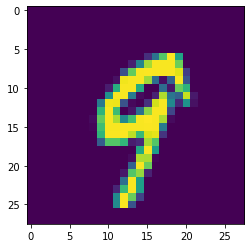

In [24]:
plt.imshow(img)

In [25]:
labels[0]

tensor(9)

In [26]:
labels[:10]

tensor([9, 9, 0, 1, 9, 5, 9, 7, 0, 6])

In [27]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)

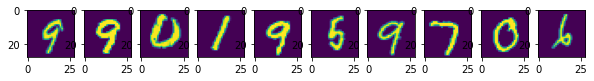

In [28]:
plt.figure(figsize=(10, 1))
for i, img in enumerate(imgs[:10]):
    plt.subplot(1, 10, i+1)
    imshow(img)

In [29]:
labels[:10]

tensor([9, 9, 0, 1, 9, 5, 9, 7, 0, 6])

# Tensorboard 导入

In [30]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./logs/mnist')

### 显示图片

In [42]:
images, labels = next(iter(train_dl))

# create grid of images
img_grid = torchvision.utils.make_grid(images[-8:])

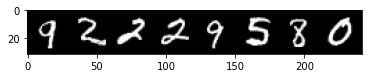

In [43]:
npimg = img_grid.permute(1, 2, 0).numpy()
plt.imshow(npimg)

In [41]:
writer.add_image('eight_mnist_images', img_grid)

### 动态显示

In [44]:
writer.add_image('eight_mnist_images_last', img_grid)

# 创建模型

In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)   
        self.pool = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.liner_1 = nn.Linear(16*4*4, 256)
        self.liner_2 = nn.Linear(256, 10)
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
#        print(x.size())    # torch.Size([64, 16, 4, 4])
        x = x.view(-1, 16*4*4)
        x = F.relu(self.liner_1(x))
        x = self.liner_2(x)
        return x

In [48]:
model = Model()

### 显示模型

In [51]:
writer.add_graph(model, images)

### 动态显示训练过程中的loss 和 acc的变化

In [52]:
model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (liner_1): Linear(in_features=256, out_features=256, bias=True)
  (liner_2): Linear(in_features=256, out_features=10, bias=True)
)

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数

In [54]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    
    writer.add_scalar('training loss',
                        epoch_loss,
                        epoch)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
    writer.add_scalar('test loss',
                        epoch_test_loss,
                        epoch)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [55]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
epochs = 20

In [57]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.004 accuracy: 0.919 test_loss：  0.0 test_accuracy: 0.97
epoch:  1 loss：  0.001 accuracy: 0.975 test_loss：  0.0 test_accuracy: 0.976
epoch:  2 loss：  0.001 accuracy: 0.982 test_loss：  0.0 test_accuracy: 0.985
epoch:  3 loss：  0.001 accuracy: 0.986 test_loss：  0.0 test_accuracy: 0.987
epoch:  4 loss：  0.001 accuracy: 0.988 test_loss：  0.0 test_accuracy: 0.987
epoch:  5 loss：  0.0 accuracy: 0.99 test_loss：  0.0 test_accuracy: 0.989
epoch:  6 loss：  0.0 accuracy: 0.992 test_loss：  0.0 test_accuracy: 0.99
epoch:  7 loss：  0.0 accuracy: 0.993 test_loss：  0.0 test_accuracy: 0.99
epoch:  8 loss：  0.0 accuracy: 0.994 test_loss：  0.0 test_accuracy: 0.987
epoch:  9 loss：  0.0 accuracy: 0.995 test_loss：  0.0 test_accuracy: 0.989
epoch:  10 loss：  0.0 accuracy: 0.996 test_loss：  0.0 test_accuracy: 0.991
epoch:  11 loss：  0.0 accuracy: 0.996 test_loss：  0.0 test_accuracy: 0.988
epoch:  12 loss：  0.0 accuracy: 0.997 test_loss：  0.0 test_accuracy: 0.988
epoch:  13 loss：  0.0 accurac

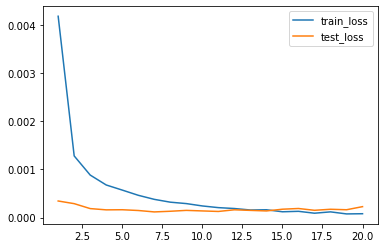

In [58]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

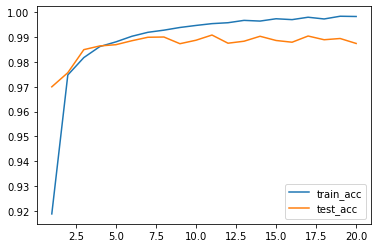

In [59]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()